In [1]:
# Restructure of program into functions 
    # Data structures for scrape/request log and support/resistance (predicted vs actual)
    # L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
        # Timestamp issue for 15m chart  
# One hot encoding into function       
# Function to reshape data into LSTM/GRU input shape             
# Further reshaping of input/test data for LSTM/GRU model 

In [2]:
# Imports
import pandas as pd
import numpy as np
import requests
import json
from json import loads
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick_ohlc,candlestick2_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
    # https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

# API-specific imports (local install)
import gdax
    # Python setup.py install with environment activaated to install/use
    # Do not use default gdax pip install package - that version of the package is currently broken

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

# autoSR() import requirements
from sklearn.cluster import MeanShift, estimate_bandwidth
from pandas_datareader import data, wb

###########################################################################
### Force Keras/TF to use CPU backend when GPU present by setting:
    # {'CPU' : 1, 'GPU' : 0}
    
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)
###########################################################################

# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Verify GPU availability for tensorflow backend
print(device_lib.list_local_devices())
print("==============================================")
print(K.tensorflow_backend._get_available_gpus())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17731035463855917846
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9222031934
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9998023184480433207
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
# Request log load
request_log_df= pd.read_csv("test_data/request_log.csv",dtype ={'epoch':object})
request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]
print(request_start)
print(request_end)

2018-04-17T00:55:03.354Z
2018-04-17T01:05:03.469Z


In [5]:
# Global variables

# Boolean to drop existing mongo collection/scrape upon scrape() init
dropFlag = False

# Boolean to set size_delta to l2update values for first update to snapshot
#firstUpdate = False
firstUpdate_bids = False
firstUpdate_asks = False

# Value to track if feature_creation_inital() was run
feature_creation_intital_run = False

In [6]:
# Connection establishment

# Establish connection to GDAX public endpoint
public_client = gdax.PublicClient()

# Mongo database and collection specification:
mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client.btcusd_db
btcusd_collection = db.btcusd_collection

In [7]:
# Function to start scrape process from websocket to mongodb instance
def scrape_start():
    
    # Drop existing collection from db if dropFlag == True (on new scrape):
    if 'btcusd_db' in mongo_client.database_names() and dropFlag is True:
        db['btcusd_db'].drop_collection('btcusd_collection')
        #print(mongo_client.database_names())
        #print(db.collection_names())
        
    # Start instance of websocket client for L2 Orderbook + L2 update data request and scrape
    wsClient = gdax.WebsocketClient(url="wss://ws-feed.gdax.com", 
                                products=["BTC-USD"],\
                                message_type="subscribe",\
                                channels =["level2"],\
                                mongo_collection=btcusd_collection,\
                                should_print=False)
    
    # Save request open time and start websocket
    time.sleep(4)
    request_time_start=public_client.get_time()
    wsClient.start()
    
    # scrape_time is variable for time between websocket connection start and end
        # Defined in seconds
        # i.e. 600 seconds = scrape running for 10 minutes
    scrape_time = 600

    time.sleep(scrape_time)
    # Save request close time and close websocket
    request_time_end=public_client.get_time()
    wsClient.close()
    
    # Append request times for open/close of websocket stream to dataframe, save to csv
    request_log_df = pd.DataFrame.from_dict({'request start':request_time_start,'request end':request_time_end},orient ='index')
    request_log_df.to_csv("raw_data/request_log.csv",header=True,encoding='utf-8',index =True)
   

In [8]:
# Function to load and parse data from Mongo into dataframes
def load_parse():
    
    #Collection specification (in database)
    input_data = db.btcusd_collection 
    
    # Create individual dataframes for main response types: snapshot, l2update
    snapshot = pd.DataFrame(list(input_data.find({'type':'snapshot'})))
    l2update = pd.DataFrame(list(input_data.find({'type':'l2update'})))
    
    ### snapshot  response load and parse ###
    
    # Extract asks/bid individual column of array of arrays into lists
    snapshot_asks = snapshot[['asks'][0]][0]
    snapshot_bids = snapshot[['bids'][0]][0]
    
    # Convert list (of array of arrays) into dataframe
    snapshot_asks_df =pd.DataFrame(snapshot_asks)
    snapshot_bids_df =pd.DataFrame(snapshot_bids)
    
    # Rename columns to snapshot array format:
        # snapshot array format: [price, size]
            # [side, price, size] format for one-hot encoding
        # Ask = sell price, bid = buy price
    snapshot_asks_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_bids_df.rename(columns ={0:'price',1:'size'}, inplace =True)
    snapshot_asks_df['side'] = "sell"
    snapshot_bids_df['side'] = "buy"
    cols =['side','price','size']
    snapshot_asks_df = snapshot_asks_df[cols]
    snapshot_bids_df = snapshot_bids_df[cols]
    
    ### L2 update response load and parse ###
    
    # Restucture l2update to have [side,price,size] from 'changes' column
    l2update_clean = l2update[['changes','time']]
          
    # Convert changes list of lists -> into array 
    l2_array = np.ravel(l2update_clean['changes']) 
    # Flatten the list and remove outer bracket:
    flattened = [val for sublist in l2_array for val in sublist]
        # Reference: https://stackoverflow.com/questions/11264684/flatten-list-of-lists?
    # Convert back to dataframe and combine with timestamps from l2update:
    changes_df= pd.DataFrame.from_records(flattened)
    # Add time column back to L2 update dataframe
    l2update_formatted = pd.concat([changes_df,l2update_clean['time']],1)
    # Rename columns for [side, price, size]:
    l2update_formatted.rename({0:"side",1:"price",2:"size"}, axis ='columns',inplace=True)
    
    # Save parsed data to csv (API -> Mongo -> Dataframe -> .csv)
    save_csv()
    
def save_csv():
    
    # Save data to .csv format in raw_data folder
    l2update_formatted.to_csv("raw_data/l2update.csv",header=True,encoding='utf-8',index =False)
    snapshot_asks_df.to_csv("raw_data/snapshot_asks.csv",header=True,encoding='utf-8',index =False)
    snapshot_bids_df.to_csv("raw_data/snapshot_bids.csv",header=True,encoding='utf-8',index =False)
    subscriptions.to_csv("raw_data/subscriptions.csv",header=True,encoding='utf-8',index =False)

In [9]:
# Function to read in data from csv into dataframes
    # Currently not working due to variable scope assignment for dataframes/reading in data from CSV

# Test data
#def data_read_test():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("test_data/request_log.csv")
    

    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

# Raw data
#def data_read_raw():
    
    # Read in test data for L2 orderbook state (bids + asks)
    # Read in test data for subsquent L2 orderbook update states (L2 updates to bid + asks)
    #snapshot_asks_df = pd.read_csv("raw_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
    #snapshot_bids_df = pd.read_csv("raw_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
    #l2update_df = pd.read_csv("raw_data/l2update.csv", dtype ={'size':float})
    #request_log_df= pd.read_csv("raw_data/request_log.csv")
    
    # Convert size column to float type for l2 updates
    #l2update_df['size'] = l2update_df['size'].apply(pd.to_numeric)
    #snapshot_bids_df['size_delta'] = snapshot_bids_df['size_delta'].apply(pd.to_numeric)

In [10]:
###########################################################################

# Section to read in data from csv (definition scope of functions above not working for assignment:)
    # Load in test data for development/debugging

snapshot_asks_df = pd.read_csv("test_data/snapshot_asks.csv",dtype ={'size':float,'size_delta':float})
snapshot_bids_df = pd.read_csv("test_data/snapshot_bids.csv",dtype ={'size':float,'size_delta':float})
l2update_df = pd.read_csv("test_data/l2update.csv", dtype ={'size':float})
request_log_df= pd.read_csv("test_data/request_log.csv")

###########################################################################

In [11]:
##### Request 15minute chart data #####

#def chart_15m_request(request_log_df):

request_start = request_log_df['iso'][1]
request_end = request_log_df['iso'][0]

# Request 15 minutes of candlestick (open high low close) data from API
    # start time must be in ISO 8601 format for get_product_historic_rates()
chart_15m = public_client.get_product_historic_rates('BTC-USD', start =request_start, granularity=60)

# Convert chart data response into dataframes
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,"close", "volume"])

# Reorder columns according to label order required by matplotlib finance package
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]

# Reverse/sort timestamp order (without reversal chart labels/axis will be out of order)
chart_15m_df.sort_values(by='time',axis=0, inplace =True)

#Convert/sort time to datetime object (for matplotlib chart format requirement)
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
    
    

In [12]:
# Auto support/resistance adapted into function 
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
    # Takes dataframe object with open/high/low/close values 
        # Returns list of auto-generated support and resistance levels for price action
def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
            # Remove duplicate S/R level values
            # Using sets
            ml_set =set(ml_results)
            ml_results = list(ml_set)
            # Sort values before return output 
            ml_results.sort()
            
    return ml_results

In [13]:
def generate_chart(dataframe):
    
    dataframe = chart_15m_df 
    
    # Generate chart of past 15 minutes with autogenerated support and resistance levels:
    fig, ax = plt.subplots(figsize=(20, 10)
                         )
    candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                      colorup='k',colordown='r',alpha=.5)
    ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(17))
        # n + 2 for proper labe set at 20,18 chart size
        # 15 + 2 =17
    plt.yticks(np.arange(int(min(chart_15m_df['low'])-5), max(chart_15m_df['high'])+10, 5))
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    #ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', pad=10)
    ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
    matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
    
    # Add S/R labels to right side of chart
    ml_results = autoSR(chart_15m_df)
    for k in ml_results:
        plt.axhline(y=k)

    #plt.tight_layout()
    return plt.show()
    #return plt.show(), ml_results

In [14]:
# create and set inital/placeholder values for size_delta, position, and sr_prox_value/line input features 
    # run once upon new scrape only
def feature_creation_inital():
    #global feature_creation_intital_run
    
    #if feature_creation_inital_run() == False:
        #global feature_creation_intital_run
        
        
        
    # Set inital size delta l2 snapshot - use decimal point to force as float
    snapshot_asks_df['size_delta'] = 0.0
    snapshot_bids_df['size_delta'] = 0.0

    # Set inital position for l2 snapshot
    snapshot_asks_df['position'] = snapshot_asks_df.index +1
    snapshot_bids_df['position'] = snapshot_bids_df.index +1

    # Reverse index for sell/asks
    # snapshot_asks_df =snapshot_asks_df[::-1]
    # Reverse inital position indicator for bids/buy side
    rev = snapshot_bids_df['position'].values * -1
    snapshot_bids_df['position'] = rev

    # Set inital proximity value and inital value for nearest prox line
    snapshot_asks_df['sr_prox_value'] = 0
    snapshot_asks_df['sr_prox_line'] = 0
    snapshot_bids_df['sr_prox_value'] = 0
    snapshot_bids_df['sr_prox_line'] = 0

    # Set feature_creation_inital_run flag to True once run
    feature_creation_inital_run = True
        
        
        
    #elif feature_creation_inital_run == True:
        #global feature_creation_intital_run
        # Required syntax for logical operator/ if-else structure, but does nothing as a result
        # i.e., a "pass"
        
        #print("pass")
        #pass
        

In [15]:
# L2 update states applied to snapshot over a defined interval (15m, in sync with chart update)
    # Applied to both snapshot_bids_df and snapshot_asks_df
    # Must be run before sr_update()
def l2_state_update():
    
    global firstUpdate_bids 
    global firstUpdate_asks
    
    for i in range(len(snapshot_bids_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_bids_df['price'].values[i])
            snapshot_bids_df.drop(snapshot_bids_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_bids == False:
            snapshot_bids_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_bids = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_bids_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_bids_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for bids snapshot
        snapshot_bids_df['position'] = snapshot_bids_df.index + 1
        rev = snapshot_bids_df['position'].values * -1
        snapshot_bids_df['position'] = rev 

    for i in range(len(snapshot_asks_df)):

        # If size in l2update_df is 0, remove that row/price point from the orderbook state
        if l2update_df['size'].values[i] == 0:
            #print (snapshot_asks_df['price'].values[i])
            snapshot_asks_df.drop(snapshot_asks_df.index[i])

        #First update to snapshot, set 'size_delta' to l2update values
            # Note: Keep here or move to end of feature_creation_inital depending on execution order
        elif l2update_df['size'].values[i] != 0 & firstUpdate_asks == False:
            snapshot_asks_df['size_delta'].values[i] = l2update_df['size'].values[i]
            firstUpdate_asks = True
        #Subsequent size delta calc
        elif l2update_df['size'].values[i] != 0:
            currentsize =snapshot_asks_df['size'].values[i] 
            updatesize = l2update_df['size'].values[i]
            snapshot_asks_df['size_delta'].values[i] = updatesize-currentsize

        # Update positional values for_asks snapshot
        snapshot_asks_df['position'] = snapshot_asks_df.index + 1
        #rev = snapshot_asks_df['position'].values * -1
        #snapshot_asks_df['position'] = rev 

In [16]:
# Function to update sr_prox_line and sr_prox_value between orderbook states
    # Note: l2_state_update applied first, then sr_update(); switch order if linear calls or switch execution block cell
    # Must be run before model input in sequence
def sr_update():
    
    # Convert to array for loop value traversal        
    ml_results_modified_array = np.array(ml_results_modified)

    ### snapshot_asks sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_asks_df['price'])):
        #if snapshot_asks_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_asks_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_asks_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_asks_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_asks_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

    ### snapshot_bids sr_prox_line,sr_prox_value set ###
    for i in range(len(snapshot_bids_df['price'])):
        #if snapshot_bids_df['price'].values[i] in ml_results_modified: 
            priceInt = int(snapshot_bids_df['price'].values[i])
            diff =abs(ml_results_modified - priceInt)
            diff_array = np.array(diff)
            lowest_abs =min(diff)
            #print("=============================")
            #print("Price: ")
            #print(snapshot_bids_df['price'].values[i])
            #print("Diff:")
            #print(diff)
            #print("lowest_abs value: ")
            #print(lowest_abs)
            minIndex= list(diff_array).index(lowest_abs)
            #print("Closest S/R line:")
            #print(ml_results_modified[minIndex])
            #print("=============================")

            #Set sr_prox_value to distance from closest S/R line
            snapshot_bids_df['sr_prox_value'].values[i] = lowest_abs
            #Set sr_prox_line value
            snapshot_bids_df['sr_prox_line'].values[i] = ml_results_modified[minIndex]

In [17]:
###########################################################################
###########################################################################
###########################################################################


# Debugging:

In [18]:
# Assignment of ml_results from function:
ml_results = autoSR(chart_15m_df)
autoSR(chart_15m_df)

[8910.01,
 8910.7,
 8919.98,
 8942.37,
 8944.89,
 8964.64,
 8974.2,
 8974.21,
 8991.0,
 9038.97,
 9100.0,
 9114.97,
 9116.83,
 9142.8,
 9156.57,
 9159.99,
 9171.0,
 9174.99,
 9191.0,
 9221.4]

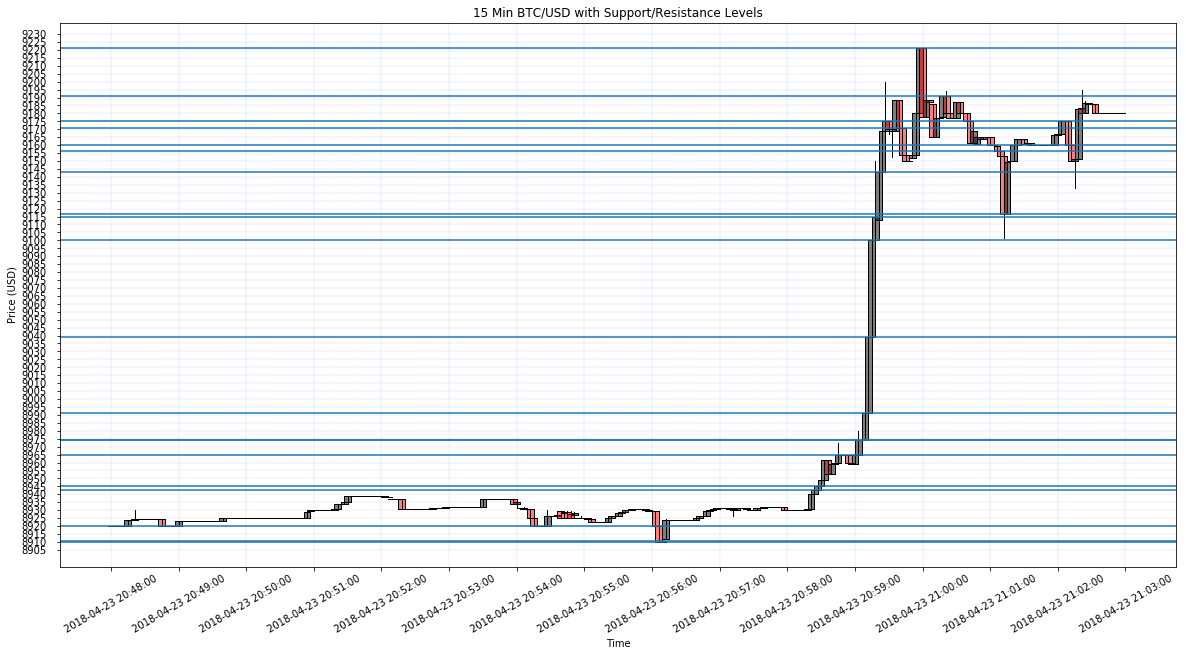

In [19]:
generate_chart(chart_15m_df)

In [20]:
# Data structures for scrape/request log and support/resistance (predicted vs actual)
    # request start, request end
    # current s/r levels: chart 15m data + ml_results (actual)
    # predicted s/r levels: ml_results (predicted)
    # current s/r levels vs predicted for current timeframe (training vs testing)

# Convert ml_results into sorted int array
ml_results_modified =np.asarray(ml_results)
ml_results_modified =np.trunc(ml_results_modified).astype(int)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort') 
# Remove duplicates from int conversion
ml_results_modified_set=set(ml_results_modified)
ml_results_modified = list(ml_results_modified_set)
ml_results_modified = np.sort(ml_results_modified,kind = 'quicksort')
ml_results_modified

array([8910, 8919, 8942, 8944, 8964, 8974, 8991, 9038, 9100, 9114, 9116,
       9142, 9156, 9159, 9171, 9174, 9191, 9221])

In [21]:
snapshot_asks_df.head()

,side,price,size
0,sell,8042.91,10.656147
1,sell,8042.92,0.001181
2,sell,8042.93,0.001305
3,sell,8042.94,0.001181
4,sell,8042.95,1.265966


In [22]:
feature_creation_inital()

In [23]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.0,1,0,0
1,sell,8042.92,0.001181,0.0,2,0,0
2,sell,8042.93,0.001305,0.0,3,0,0
3,sell,8042.94,0.001181,0.0,4,0,0
4,sell,8042.95,1.265966,0.0,5,0,0


In [24]:
l2_state_update()

In [25]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,0,0
1,sell,8042.92,0.001181,0.020,2,0,0
2,sell,8042.93,0.001305,0.000,3,0,0
3,sell,8042.94,0.001181,0.001,4,0,0
4,sell,8042.95,1.265966,0.000,5,0,0


In [26]:
sr_update()

In [27]:
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,868,8910
1,sell,8042.92,0.001181,0.020,2,868,8910
2,sell,8042.93,0.001305,0.000,3,868,8910
3,sell,8042.94,0.001181,0.001,4,868,8910
4,sell,8042.95,1.265966,0.000,5,868,8910


In [28]:
###########################################################################

# Inital snapshot state ---> First L2 updates + features applied = First complete state to feed into model
    # state 0: [price,size,size_delta,position,sr_prox_value,sr_prox_line]
        # State 0 = 15 minutes of data as unit
    # ml_results_modified is y value

In [29]:
# Results for predicted S/R levels may vary in total element/array length
    # But will still be array similar in shape to the below
ml_results_modified

array([8910, 8919, 8942, 8944, 8964, 8974, 8991, 9038, 9100, 9114, 9116,
       9142, 9156, 9159, 9171, 9174, 9191, 9221])

In [30]:
np.size(ml_results_modified)

18

In [31]:

# Information about snapshot_asks_df for input shape information
snapshot_asks_df.head()

,side,price,size,size_delta,position,sr_prox_value,sr_prox_line
0,sell,8042.91,10.656147,0.000,1,868,8910
1,sell,8042.92,0.001181,0.020,2,868,8910
2,sell,8042.93,0.001305,0.000,3,868,8910
3,sell,8042.94,0.001181,0.001,4,868,8910
4,sell,8042.95,1.265966,0.000,5,868,8910


In [32]:
data = snapshot_asks_df.values
X = data[:,2:6]
y = data[:,6:7]
y = np.ravel(y)
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_y = encoded_y.reshape(len(encoded_y), 1)
onehot_y = onehot_encoder.fit_transform(encoded_y)

In [33]:
X

array([[10.65614728, 0.0, 1, 868],
       [0.00118097, 0.02, 2, 868],
       [0.00130538, 0.0, 3, 868],
       ...,
       [0.00104855, 2.0, 16995, 9987645100],
       [0.013999999999999999, 1.24231, 16996, 9999990777],
       [0.02839242, 0.00375, 16997, 9999990778]], dtype=object)

In [34]:
y

array([8910, 8910, 8910, ..., 9221, 9221, 9221], dtype=object)

In [35]:
encoded_y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [17],
       [17],
       [17]], dtype=int64)

In [36]:
onehot_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
# Shape information for input shaping
print(data.shape)
print("Shape without side column :")
print(X.shape)
print(y.shape)
print(onehot_y.shape)

(16997, 7)
Shape without side column :
(16997, 4)
(16997,)
(16997, 18)


In [38]:
print(X.shape)
Xshapetest = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(Xshapetest.shape)

(16997, 4)
(16997, 1, 4)


In [101]:
Xshapetest.shape[0]

16997

In [39]:
print(onehot_y.shape)

(16997, 18)


In [130]:
# Model construction
    #https://keras.io/getting-started/faq/#how-can-i-use-stateful-rnns
    #https://keras.io/getting-started/sequential-model-guide/
#max_features = 5
model = Sequential()
#model.add(Embedding(7, 2500))
    #https://keras.io/layers/embeddings/
#model.add(LSTM(512, input_shape=(Xshapetest.shape[1], Xshapetest.shape[2]),\
               #dropout=0.1, recurrent_dropout=0.2,return_sequences=True,stateful=True))
    
batch_size = Xshapetest.shape[0]

model.add(LSTM(1024, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size , Xshapetest.shape[1], Xshapetest.shape[2])))
    #input_shape(timesteps,features)
model.add(LSTM(512, return_sequences=True,stateful=True ))
model.add(LSTM(256, return_sequences=True,stateful=True ))
model.add(LSTM(128, return_sequences=False,stateful=True ))
model.add(Dense(onehot_y.shape[1], activation='relu'))
model.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (16997, 1, 1024)          4214784   
_________________________________________________________________
lstm_79 (LSTM)               (16997, 1, 512)           3147776   
_________________________________________________________________
lstm_80 (LSTM)               (16997, 1, 256)           787456    
_________________________________________________________________
lstm_81 (LSTM)               (16997, 128)              197120    
_________________________________________________________________
dense_30 (Dense)             (16997, 18)               2322      
Total params: 8,349,458
Trainable params: 8,349,458
Non-trainable params: 0
_________________________________________________________________


In [129]:
#model.reset_states()

In [131]:
model.fit(
    Xshapetest,
    onehot_y, 
    epochs=100,
    shuffle=False, #Set shuffle to false when stateful = True in model definition above
    verbose=2,
    batch_size=batch_size  #validation_data=(X, onehot_y)
)

Epoch 1/100
 - 5s - loss: 8.3426 - acc: 0.0637
Epoch 2/100
 - 0s - loss: 1.2718 - acc: 0.7980
Epoch 3/100
 - 0s - loss: 0.9980 - acc: 0.7980
Epoch 4/100
 - 0s - loss: 1.1237 - acc: 0.7980
Epoch 5/100
 - 0s - loss: 1.3913 - acc: 0.7980
Epoch 6/100
 - 0s - loss: 1.4313 - acc: 0.7980
Epoch 7/100
 - 0s - loss: 1.3993 - acc: 0.7980
Epoch 8/100
 - 0s - loss: 1.3402 - acc: 0.7980
Epoch 9/100
 - 0s - loss: 1.2653 - acc: 0.7980
Epoch 10/100
 - 0s - loss: 1.1750 - acc: 0.7980
Epoch 11/100
 - 0s - loss: 1.1110 - acc: 0.7980
Epoch 12/100
 - 0s - loss: 1.1059 - acc: 0.7980
Epoch 13/100
 - 0s - loss: 1.1005 - acc: 0.7980
Epoch 14/100
 - 0s - loss: 1.0977 - acc: 0.7980
Epoch 15/100
 - 0s - loss: 1.0946 - acc: 0.7980
Epoch 16/100
 - 0s - loss: 1.0913 - acc: 0.7980
Epoch 17/100
 - 0s - loss: 1.0875 - acc: 0.7980
Epoch 18/100
 - 0s - loss: 1.0832 - acc: 0.8076
Epoch 19/100
 - 0s - loss: 1.0786 - acc: 0.8020
Epoch 20/100
 - 0s - loss: 1.0737 - acc: 0.8021
Epoch 21/100
 - 0s - loss: 1.0686 - acc: 0.7991
E

In [132]:
model_loss, model_accuracy=model.evaluate(Xshapetest, onehot_y, batch_size=batch_size)
print(f" Model - Loss: {model_loss}, Accuracy: {model_accuracy}")

16997/16997 [==============================] - 1s 76us/step
 Model - Loss: 0.565604567527771, Accuracy: 0.9542860388755798


In [133]:
model.predict(Xshapetest,batch_size=batch_size)


array([[1.1535863, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.1437298, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.1441727, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        2.622061 ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        2.622061 ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        2.622061 ]], dtype=float32)

In [134]:
model.predict_classes(Xshapetest,batch_size=batch_size)

array([ 0,  0,  0, ..., 17, 17, 17], dtype=int64)

In [135]:
# Breakout of model.predict results into dataframe for examination:

a =model.predict(Xshapetest,batch_size=batch_size)
a_df = pd.DataFrame(a)
print(a_df.head())
print(a_df.tail())

         0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0  1.171568  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.162025  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.162474  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.162982  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  1.164516  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    14   15   16   17  
0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  
        0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
16992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [136]:
# Reversal of categoricial and onehot encoding:

decoded = onehot_y.dot(onehot_encoder.active_features_).astype(int)
#print(decoded)
inverted = label_encoder.inverse_transform(decoded)
inverted

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([8910, 8910, 8910, ..., 9221, 9221, 9221], dtype=object)

In [47]:
#from numpy import argmax
#inverted = label_encoder.inverse_transform([argmax(onehot_y[0, :])])
#inverted = label_encoder.inverse_transform([argmax(onehot_y)])
#print(inverted)

In [48]:
# One hot encoding into function 


In [49]:
# Function to reshape data into LSTM/GRU input shape 
